# MEstimate Encoding categorical Features

In [11]:
import numpy as np
import pandas as pd
import string, time

from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from category_encoders import MEstimateEncoder

from fastai.tabular.all import *
from sklearn.model_selection import train_test_split

In [12]:
train_df = pd.read_csv("../../input/train.csv")
test_df = pd.read_csv("../../input/test.csv")

In [13]:
train_df.shape, test_df.shape

((900000, 33), (700000, 32))

In [14]:
train_df.head(2)

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,...,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,...,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1


# Splitting feature 27 intelligently

By itself, we can see that feature 27 has close to 741k unique values in a train size of 900k entries. However, we can decompose these into a set of columns and then create counts of the alphabets as a feature.

In [15]:
train_df.f_27.nunique()

741354

In [16]:
# Define a default counter for all the alphabets
default_counter = {}
for s in string.ascii_uppercase:
    default_counter[s] = 0

In [17]:
# Define a function to get the alphabet counts in each record of the train/test df
def get_counts(x):
    counts = deepcopy(default_counter)
    for letter in x:
        counts[letter] += 1
    return list(counts.values())

In [18]:
train_alphabet_counts = train_df.f_27.apply(lambda x: get_counts(x))
test_alphabet_counts = test_df.f_27.apply(lambda x: get_counts(x))

In [19]:
train_alphabet_df = pd.DataFrame(np.array(train_alphabet_counts.values.tolist()), columns = list(string.ascii_uppercase))
test_alphabet_df = pd.DataFrame(np.array(test_alphabet_counts.values.tolist()), columns = list(string.ascii_uppercase))

In [20]:
test_alphabet_df = pd.DataFrame(np.array(test_alphabet_counts.values.tolist()), columns = list(string.ascii_uppercase))

In [21]:
train_alphabet_df.describe().T

,count,mean,std,min,25%,50%,75%,max
A,900000.0,2.460909,1.348131,0.0,2.0,2.0,3.0,9.0
B,900000.0,3.244169,1.422739,0.0,2.0,3.0,4.0,10.0
C,900000.0,1.478987,1.063639,0.0,1.0,1.0,2.0,7.0
D,900000.0,1.028972,0.929393,0.0,0.0,1.0,2.0,7.0
E,900000.0,0.597529,0.734487,0.0,0.0,0.0,1.0,5.0
F,900000.0,0.315301,0.547126,0.0,0.0,0.0,1.0,5.0
G,900000.0,0.163871,0.398628,0.0,0.0,0.0,0.0,4.0
H,900000.0,0.094059,0.301564,0.0,0.0,0.0,0.0,3.0
I,900000.0,0.066087,0.251902,0.0,0.0,0.0,0.0,3.0
J,900000.0,0.055603,0.230243,0.0,0.0,0.0,0.0,3.0


We can see that `U, V, W, X, Y, Z` never appear in the corpus. Only upto T, we find some representation of these alphabets in our feature, so we will only keep these counts till alphabet T in our corpus and add them to the original dataframe.

In [22]:
train_df = pd.concat([train_df, train_alphabet_df.iloc[:, :20]], axis = 1)
test_df = pd.concat([test_df, test_alphabet_df.iloc[:, :20]], axis = 1)

In [23]:
train_df.head(3)

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,K,L,M,N,O,P,Q,R,S,T
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,...,0,0,0,0,0,0,0,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,...,0,0,0,0,0,0,0,0,0,0
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,...,1,0,0,0,0,0,0,0,0,0


In [24]:
test_df.head(3)

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,K,L,M,N,O,P,Q,R,S,T
0,900000,0.442517,0.174380,-0.999816,0.762741,0.186778,-1.074775,0.501888,6,6,...,0,1,0,0,0,0,0,0,0,0
1,900001,-0.605598,-0.305715,0.627667,-0.578898,-1.750931,1.355550,-0.190911,1,3,...,0,0,0,0,0,0,0,0,0,0
2,900002,0.303990,2.445110,0.246515,0.818248,0.359731,-1.331845,1.358622,3,3,...,1,0,0,0,0,0,0,0,0,0


In [25]:
train_df.drop(columns = ["f_27", "id"], inplace = True)
test_ids = test_df["id"]
test_df.drop(columns = ["f_27", "id"], inplace = True)

## Fit the encoder

In [29]:
y = train_df.pop("target")
X = train_df
X_train_enc, X_encode, y_train_enc, y_encode = train_test_split(X, y, test_size = 0.2, random_state = 758)

In [30]:
cat_cols = [f"f_{fnum:0>2d}" for fnum in range(7, 19)] + ["f_29" , "f_30"]
num_cols = [y for y in X_train_enc.columns if (not y in cat_cols) and (y != "id") and (y != "f_27")]

In [31]:
encoder = MEstimateEncoder(cols = cat_cols, m = 1.5)
encoder.fit(X_encode, y_encode);

In [32]:
X_train_enc = encoder.transform(X_train_enc)
X_encode = encoder.transform(X_encode)
X_test = encoder.transform(test_df)

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_enc, y_train_enc, stratify = y_train_enc, test_size = 100000, random_state = 121)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((620000, 50), (620000,), (100000, 50), (100000,))

In [34]:
y_train.value_counts()

0    318429
1    301571
Name: target, dtype: int64

In [35]:
X_train_enc.head(2)

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,K,L,M,N,O,P,Q,R,S,T
499268,-1.049401,0.554152,0.545724,1.403687,-0.978832,1.166429,-0.481448,0.495962,0.485746,0.514479,...,0,0,1,0,0,0,0,0,0,0
446929,-0.056631,-1.801325,0.975262,0.810529,0.256258,-1.913425,0.948546,0.495962,0.517931,0.458397,...,0,0,0,0,0,0,1,0,0,0


# Use fastai Tabular for creating a tabular learner and using NN for building models

In [42]:
df = deepcopy(X_train_enc)
df["target"] = y_train_enc

In [43]:
splits = RandomSplitter(valid_pct = 0.15)(df.index)

In [60]:
to = TabularPandas(df, procs=[Normalize],
                   cont_names = cat_cols + num_cols,
                   y_names='target',
                   y_block = CategoryBlock,
                   splits=splits)

In [61]:
dls = to.dataloaders(bs=64)

SuggestedLRs(valley=0.0010000000474974513)

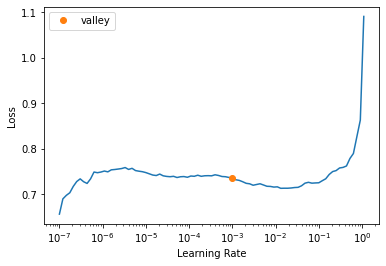

In [70]:
learn = tabular_learner(dls, metrics=[RocAucBinary()])
learn.lr_find()

In [71]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=50, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

In [72]:
learn.fit_one_cycle(10, 1.2e-3)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.436359,0.419383,0.891266,01:12
1,0.369275,0.344776,0.927422,01:11
2,0.317299,0.277839,0.954188,01:13
3,0.301769,0.251796,0.962658,01:12
4,0.294912,0.237450,0.966570,01:13
5,0.256410,0.218732,0.971588,01:12
6,0.259172,0.212030,0.973698,01:12
7,0.256190,0.205818,0.975440,01:12
8,0.234348,0.197403,0.977463,01:10
9,0.237313,0.196981,0.977449,01:11


In [ ]:
dl = learn.dls.test_dl(X_test)
prediction_probabilities, _ = learn.get_preds(dl=dl)
preds = prediction_probabilities.numpy()[:, 1]

In [83]:
# Predict on test data
pd.DataFrame({"id":test_ids,
              "target":preds}).to_csv("../../submissions/May_2022/submission_fastai_MEstimator_encoding.csv", index = None)

In [84]:
!kaggle competitions submit -c tabular-playground-series-may-2022 -f ../../submissions/May_2022/submission_fastai_MEstimator_encoding.csv -m "fastai with MEstimator Encoding Submission"

100%|██████████████████████████████████████| 12.6M/12.6M [00:05<00:00, 2.21MB/s]
Successfully submitted to Tabular Playground Series - May 2022